In [1]:
%matplotlib inline
import fsps
import matplotlib.pyplot as plt
import numpy as np

* add_igm_absorption includes IGM absorption via Madau 1995
* zred is redshift
* zmet = 1.0 by default, metallicity 
* sfh = 0 is SSP model (all stars have same age and metallicity) 
* tage = Myr age

In [2]:
sp = fsps.StellarPopulation(zred=3., const=1.0, sfh=3, tage=0.5, add_igm_absorption=True, zmet = 1. )

C

In [3]:
a = np.arange(0.1, 0.6, 0.1)
sfr = np.full(5, 5.0)

In [4]:
sp.set_tabular_sfh(age = a, sfr = sfr)

Things that still need:
* Small dust absorption (relation to attenuation?

Below we print the AB magnitudes in desired bands. They are extremely faint right now and I think this is because the star formation rate is by default normalized to 1. I need to figure out how to make it 5. 

In [5]:
mags = sp.get_mags(zmet = 1., tage=0.5, bands=['wfc_acs_f435w', 'wfc_acs_f606w', 'wfc_acs_f775w', 'wfc_acs_f850lp', 'wfc3_ir_f105w', 'wfc3_ir_f125w', 'wfc3_ir_f160w', 'jwst_f200w', 'jwst_f277w', 'jwst_f356w', 'jwst_f444w'])
print 'HST F435W: ', mags[0]
print 'HST F606W: ', mags[1]
print 'HST F775W: ', mags[2]
print 'HST F850LP: ', mags[3]
print 'HST F105W: ', mags[4]
print 'HST F125W: ', mags[5]
print 'HST F160W: ', mags[6]
print 'JWST F200W: ', mags[7]
print 'JWST F277W: ', mags[8]
print 'JWST F356W: ', mags[9]
print 'JWST F444W: ', mags[10]

HST F435W:  25.3187981793
HST F606W:  24.9117228304
HST F775W:  25.0022558637
HST F850LP:  25.0908821144
HST F105W:  25.1798370387
HST F125W:  25.2868020624
HST F160W:  25.1546462864
JWST F200W:  25.1733064664
JWST F277W:  25.3962272289
JWST F356W:  25.5068294376
JWST F444W:  25.6183121457


In [6]:
wave, spec = sp.get_spectrum(zmet = 1., tage = 0.5)

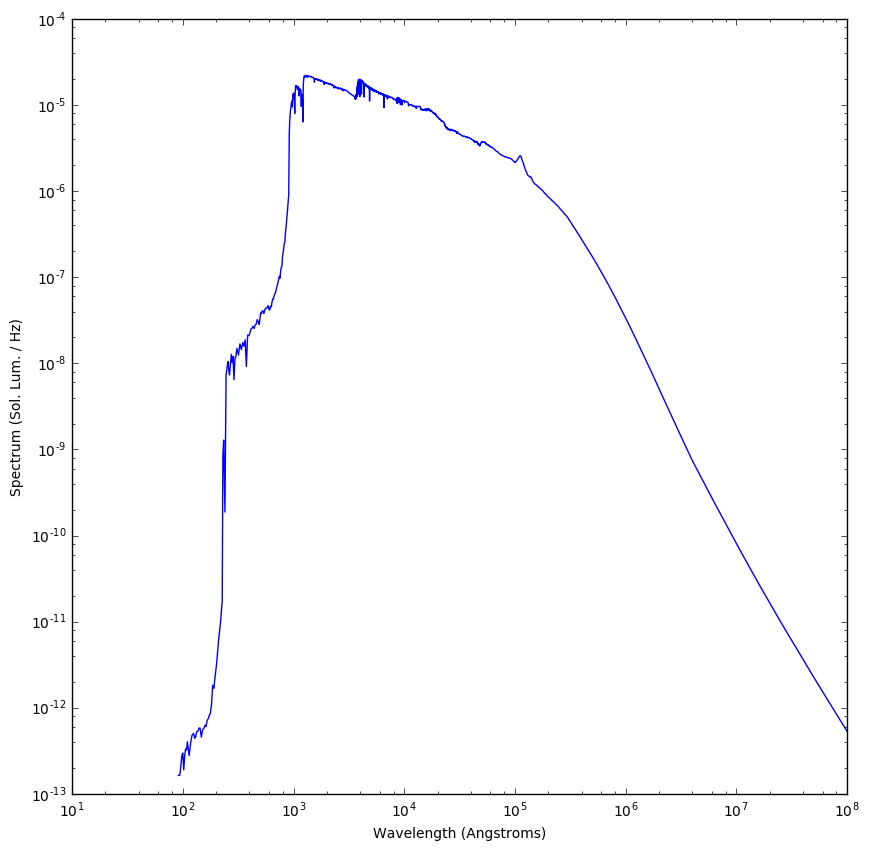

In [7]:
fig = plt.figure(figsize=[10,10])
plt.plot(wave, spec)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Spectrum (Sol. Lum. / Hz)')